<a href="https://colab.research.google.com/github/CanKeles5/SequenceModels/blob/main/TEIA%C5%9E_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import torch
torch.cuda.is_available()
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
device = torch.device(dev)

In [21]:
device

device(type='cpu')

In [1]:
%matplotlib inline

In [2]:
! pip install pickle5

     |████████████████████████████████| 133kB 4.3MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp36-cp36m-linux_x86_64.whl size=218620 sha256=7d10e2d1edc26863e0fc8e8f9d9f913dc466a9a28200cb19cadcdec911e73000
  Stored in directory: /root/.cache/pip/wheels/a6/90/95/f889ca4aa8b0e0c7f21c8470b6f5d6032f0390a3a141a9a3bd
Successfully built pickle5


In [3]:
import pickle5
from math import sqrt
from datetime import datetime
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
with open('/content/20210101-epias-raw.pkl', 'rb') as f:
    data = pickle5.load(f)

Drop all colums of zeros: df.loc[:, (df != 0).any(axis=0)]


In [5]:
new_data = data.loc[:, (data != 0).any(axis=0)] #(index=False)

In [6]:
new_data = new_data.drop(['date', 'ltotal',	'lwind',	'lbiogas',	'lcanalType',	'lbiomass',	'lsun',	'lothers'], axis=1)

In [7]:
(new_data)

,fueloil,blackCoal,lignite,geothermal,naturalGas,river,dammedHydro,lng,biomass,naphta,importCoal,asphaltiteCoal,wind,sun,importExport,total
0,29.2,0.00,551.00,0.00,2326.01,151.49,502.38,9.3,26.35,0.0,1184.00,0.00,2.00,0.0,0.00,4781.73
1,29.1,0.00,544.00,0.00,2334.78,152.77,441.94,9.3,27.07,0.0,1184.00,0.00,2.00,0.0,0.00,4724.96
2,29.1,0.00,547.00,0.00,2157.76,151.47,430.19,9.3,26.88,0.0,1185.00,0.00,2.00,0.0,0.00,4538.70
3,29.0,0.00,547.00,0.00,2084.72,125.83,275.18,9.4,25.67,0.0,1183.00,0.00,1.00,0.0,0.00,4280.80
4,28.3,0.00,549.00,0.00,2034.68,124.35,271.86,9.4,26.45,0.0,1066.00,0.00,1.00,0.0,0.00,4111.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67263,36.3,625.95,4916.02,1237.17,8912.15,1252.61,6215.11,0.0,581.21,0.0,7909.62,220.80,1265.85,0.0,-167.33,33005.46
67264,36.2,620.18,4808.25,1238.56,9068.42,1153.29,5573.13,0.0,563.34,0.0,7795.01,223.00,1262.36,0.0,-151.42,32190.32
67265,36.9,637.67,4755.74,1244.27,9164.25,1058.40,4897.53,0.0,561.40,0.0,7772.89,223.00,1286.04,0.0,-159.21,31478.88
67266,36.6,651.68,4765.78,1243.95,9240.85,1026.27,4426.24,0.0,567.91,0.0,7785.29,220.80,1219.27,0.0,-169.87,31014.77


In [8]:
new_data = new_data.to_numpy()

To-do:
  Get the data in such a format that it can work with the other notebook.
  
  1- Extract the date element.

  2- Normalize all features in the input part of the data.

  3- Create the inputs and the targets.

  4- Create train and test sets.

  5- 

  6- 

In [9]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


In [10]:
# integer encode direction
#encoder = LabelEncoder()
#values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float

#values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(new_data)
# specify the number of lag hours
n_hours = 1
n_features = 15
# frame as supervised learning

reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.shape)

(67267, 32)


In [11]:
reframed = reframed.to_numpy()

In [12]:
n_train_hours = 50000
train = reframed[:n_train_hours, :]
test = reframed[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(50000, 15) 50000 (50000,)
(50000, 1, 15) (50000,) (17267, 1, 15) (17267,)


In [13]:
train_X.shape[0]

50000

In [14]:
test_X.shape[0]

17267

In [15]:
class LSTM(nn.Module):

  def __init__(self):
    super(LSTM, self).__init__()

    self.lstm = nn.LSTM(input_size=15, hidden_size=50, num_layers=1)
    self.FC = nn.Linear(50, 1)

  def forward(self, input):
    pred, _ = self.lstm(input)

    pred = self.FC(pred.view(50))

    return pred

In [22]:
model = LSTM().to(device)

In [17]:
loss_function = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-6)

In [18]:
train_loss_hist = []
test_loss_hist = []

In [19]:
for epoch in range(20):
  train_loss = 0.0
  test_loss = 0.0

  for i in range(train_X.shape[0]):
    data = torch.Tensor(train_X[i]).unsqueeze(0)
    data = data.to(device)

    optimizer.zero_grad()

    prediction = model(data)

    #print("Train --- prediction: " + str(prediction) + " , GT: " + str(train_y[i]))

    loss = loss_function(prediction, torch.Tensor([train_y[i]]))

    train_loss += loss.item()

    loss.backward()
    optimizer.step()

  with torch.no_grad():
    for i in range(test_X.shape[0]):
      data = torch.Tensor(test_X[i]).unsqueeze(0)
      data = data.to(device)

      prediction = model(data)

      #print("Validate --- prediction: " + str(prediction) + " , GT: " + str(test_y[i]))

      loss = loss_function(prediction, torch.Tensor([test_y[i]]))
      test_loss += loss.item()

  train_loss = train_loss / train_X.shape[0]
  test_loss = test_loss / test_X.shape[0]

  train_loss_hist.append(train_loss)
  test_loss_hist.append(test_loss)

  print("Train loss: " +  str(train_loss) + " --- Test loss: " + str(test_loss))


Train loss: 0.3552082933442295 --- Test loss: 0.1875191728038145
Train loss: 0.09836252043500543 --- Test loss: 0.14585006359487593
Train loss: 0.09213301954463124 --- Test loss: 0.14343007538786304


KeyboardInterrupt: ignored

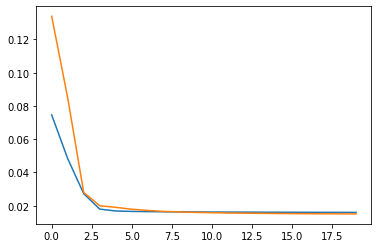

In [ ]:
pyplot.plot(train_loss_hist)
pyplot.plot(test_loss_hist)
